[View in Colaboratory](https://colab.research.google.com/github/samik-saha/kaggle/blob/master/rsna/colab_RSNA_pneumonia_detecion.ipynb)

In [1]:
!pip install kaggle
!export KAGGLE_USERNAME="samik01";export KAGGLE_KEY="77cc422dd5d3f614b716fd353fe4e034";kaggle competitions download -c rsna-pneumonia-detection-challenge

    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 235kB 4.9MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/44/2c/df/22a6eeb780c36c28190faef6252b739fdc47145fd87a6642d4
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify
  0% 0.00/55.0 [00:00<?, ?B/s]
100% 55.0/55.0 [00:00<00:00, 34.6kB/s]
  0% 0.00/561k [00:00<?, ?B/s]
100% 561k/561k [00:00<00:00, 83.5MB/s]
  0% 0.00/51.8k [00:00<?, ?B/s]
100% 51.8k/51.8k [00:00<00:00, 24.2MB/s]
  0% 0.00/634k [00:00<?, ?B/s]
100% 634k/634k [00:00<00:00, 112MB/s]
 96% 121M/126M [00:01<00:00, 88.4MB/s]
100% 126M/126M [00:01<00:00, 104MB/s] 
100% 3.16G/3.17G [01:31<00:00, 27.7MB/s]
100% 3.17G/3.17G [01:31<00:00, 37.2MB/s]


In [0]:
!unzip stage_1_train_images.zip -d stage_1_train_images>/dev/null
!unzip stage_1_train_labels.csv.zip>/dev/null
!unzip stage_1_detailed_class_info.csv.zip>/dev/null

In [3]:
!ls

GCP%20Credits%20Request%20Link%20-%20RSNA.txt  stage_1_test_images.zip
sample_data				       stage_1_train_images
stage_1_detailed_class_info.csv		       stage_1_train_images.zip
stage_1_detailed_class_info.csv.zip	       stage_1_train_labels.csv
stage_1_sample_submission.csv		       stage_1_train_labels.csv.zip


In [4]:
!pip install pydicom
import pandas as pd
import pydicom, numpy as np
import matplotlib.pyplot as plt

    100% |████████████████████████████████| 6.7MB 851kB/s 


In [0]:
def parse_data(df):
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]
    parsed = {}
    
    for n, row in df.iterrows():
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom':'./stage_1_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []
            }
            
        if row['Target'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))
                
    return parsed


def draw(data):
    """
    Method to draw image for single patient
    """
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array
    
    # Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)
    
    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)
    
    plt.imshow(im, cmap=plt.cm.gist_gray)
    plt.axis('off')

    
def overlay_box(im, box, rgb, stroke=1):
    box = [int(b) for b in box]
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width
    
    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb
    
    return im

In [0]:
df = pd.read_csv('stage_1_train_labels.csv')
patient_class = pd.read_csv('stage_1_detailed_class_info.csv', index_col=0)
parsed = parse_data(df)

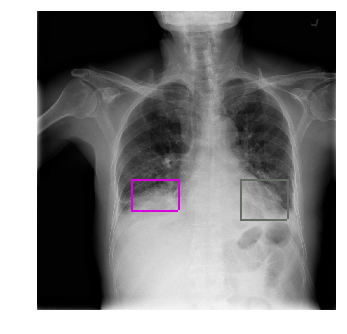

In [7]:
draw(parsed[df['patientId'][8]])

In [8]:
!pip3 install https://github.com/OlafenwaMoses/ImageAI/releases/download/2.0.2/imageai-2.0.2-py3-none-any.whl

    100% |████████████████████████████████| 153kB 2.4MB/s 


In [0]:
import keras
import random

In [0]:
class generator(keras.utils.Sequence):
  def __init__(self, data, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
    self.data = data
    self.keys = list(data.keys())
    self.batch_size = batch_size
    self.image_size = image_size
    self.shuffle = shuffle
    self.augment = augment
    self.predict = predict
    self.on_epoch_end()
  
  def __load__(self, example):
    img = pydicom.dcmread(example['dicom']).pixel_array
    msk = np.zeros(img.shape)
    for box in example['boxes']:
      box = [int(b) for b in box]
      y, x, h, w = box
      msk[y:y+h, x:x+w] = 1
    
    # resize both image and mask
    img = resize(img, (self.image_size, self.image_size), mode = 'reflect')
    msk = resize(msk, (self.image_size, self.image_size), mode = 'reflect')
    
    # if augment flip horizontally half the time
    if self.augment and random.random()>0.5:
      img = np.fliplr(img)
      msk = np.fliplr(msk)
      
    img = np.expand_dims(img, -1)
    msk = np.expand_dims(msk, -1)
  
  def __loadpredict__(self, example):
    img = pydicom.dcmread(example['dicom']).pixel_array
    img = resize(img, (self.image_size, self.image_size), mode='reflect')
    img = np.expand_dims(img, -1)
    
  def __getitem__(self, index):
    patient_ids = self.keys[index*self.batch_size:(index+1)*self.batch_size]
    if self.predict:
      imgs = [self.__loadpredict__(self.data[patient_id]) for patient_id in patient_ids]
      imgs = np.array(imgs)
      return imgs, batch_data
    else:
      items = [self.__load__(self.data[patient_id]) for patient_id in patient_ids]
      imgs, msks = zip (*items)
      return imgs, msks
    
  def on_epoch_end(self):
    if self.shuffle:
      random.shuffle(self.keys)
      
  def __len__(self):
    if self.predict:
      return np.ceil(len(self.data)/self.batch_size)
    else:
      return int(len(self.data)/self.batch_size)
  
  
      
train_gen = generator(parsed)

In [30]:
keys[0]

'0004cfab-14fd-4e49-80ba-63a80b6bddd6'